<a href="https://colab.research.google.com/github/sasha110110/future_fuel/blob/main/space_fuel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Загружаем данные

In [2]:
from google.colab import files
import pandas as pd

In [3]:
df = pd.read_parquet('/content/transactions.parquet')
#df.to_csv('transactions.csv')

In [4]:
df_nomenclature = pd.read_parquet('/content/nomenclature.parquet')

In [5]:
df_for_submission = pd.read_parquet('/content/transactions-for_submission.parquet')
#df.to_csv('transactions_for_submission.csv')

## for submission

In [6]:
df_for_submission.shape

(554730, 8)

In [ ]:
df_for_submission.head(5)

,sku_id,price,number,cheque_id,litrs,client_id,shop_id,date
0,1158,0.002304,0.000000,734259,0.142106,223748.0,42,2171-08-01 09:00:00
1,555,0.009133,0.000452,734260,0.104183,NaN,42,2171-08-01 09:00:00
2,555,0.009133,0.000452,734260,0.104183,NaN,42,2171-08-01 09:00:00
3,1158,0.002304,0.000000,734264,0.138006,NaN,42,2171-08-01 09:00:00
4,1534,0.002822,0.000452,734266,0.104183,NaN,42,2171-08-01 09:00:00


In [8]:
len(df_for_submission["cheque_id"].unique())

315228

In [7]:
submission_df=(cheque_id, sku_id, position)

NameError: ignored

In [9]:
from collections import defaultdict

In [10]:
def items_in_one(dataframe_column1, dataframe_column2):
  """returns dict for cheques items"""
  zip_list=list(zip(dataframe_column1.values, dataframe_column2.values))
  d=defaultdict(list)
  for c, i in zip_list:
    d[c].append(i)
  return d

In [ ]:
df_for_submission.isnull().count()

sku_id       554730
price        554730
number       554730
cheque_id    554730
litrs        554730
client_id    554730
shop_id      554730
date         554730
dtype: int64

In [11]:
df_for_submission.head(2)

,sku_id,price,number,cheque_id,litrs,client_id,shop_id,date
0,1158,0.002304,0.000000,734259,0.142106,223748.0,42,2171-08-01 09:00:00
1,555,0.009133,0.000452,734260,0.104183,NaN,42,2171-08-01 09:00:00


In [12]:
submission_items_in_cheque=items_in_one(df_for_submission["cheque_id"], df_for_submission["sku_id"])

In [ ]:
len(submission_items_in_cheque)

315228

In [ ]:
list(submission_items_in_cheque.values())[0]

[1158]

In [ ]:
assert len(submission_items_in_cheque)==len(df_for_submission["cheque_id"].unique())

## Основные данные

In [ ]:
df.shape

(7620119, 8)

In [ ]:
df.isnull().sum(axis = 0)

sku_id             0
price              0
number             0
cheque_id          0
litrs              0
client_id    3772355
shop_id            0
date               0
dtype: int64

Количество некоторых товарров равно 0, может, это счетчие немного сбоит, ведь категории есть в чеке. Может, их исключить из рассмотрения? или оставим

Посмотрим на некоторые данные

In [ ]:
len(df[df["number"]==0.000000])

1825416

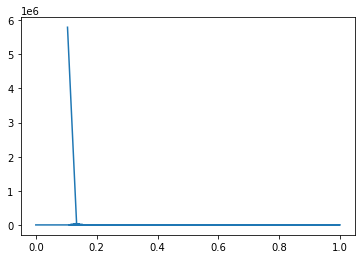

In [ ]:
df.litrs.value_counts().plot()

In [ ]:
len(df.shop_id.value_counts())

110

In [ ]:
len(df.cheque_id.unique()) 

2848238

Проверим некоторые колонки по магазинам и дням недели Посмотрим, коррелируют ли покупки с магазинами и с днями недели.

In [13]:
df['date'] = pd.to_datetime(df['date'])

df['day_of_week'] = df['date'].dt.dayofweek

In [14]:
df["is_end_of_week"]=df.day_of_week > 4

In [ ]:
df.head(1)

,sku_id,price,number,cheque_id,litrs,client_id,shop_id,date,day_of_week,is_end_of_week
0,1158,0.002335,0.0,3338297,0.147929,78634.0,102,2171-07-23,1,False


## vocab for ids, names

In [11]:
df_nomenclature.head(2)

,sku_id,full_name,brand,sku_group,OTM,units,country
0,0,Масло Lubricrol Magnatec Diesel 10W-40 B4 1л,Lubricrol,Масла моторные (для варповых двигателей),Нет,unknown,ГЕРМАНИЯ
1,723,Трос УранПРОМEthereum буксировочный 4500кг,УранПРОМEthereum,Автотовары,Да,шт,РОССИЯ


In [15]:
df_nomenclature[df_nomenclature["full_name"]=='unknown'].shape[0]

1370

In [13]:
nomenc_dict_category = items_in_one(df_nomenclature.sku_group, df_nomenclature.sku_id)

In [ ]:
 nomenc_dict_category

## df_shop_day

In [16]:
CATEGORIES=['Снеки', 'Вода', 'Сладкие Уранированные напитки, холодный чай', 'Соки и сокосодержащие напитки', 
            'Энергетические напитки', 'Кофейные напитки с молоком']

In [17]:
df_shop_day=pd.merge(df[["sku_id", "shop_id", "day_of_week", "litrs"]], df_nomenclature[["sku_id", "sku_group"]], on=["sku_id"])

In [ ]:
#df_shop_day["much_fuel_or_not"] = np.where(df_shop_day['litrs']>df_shop_day['litrs'].mean(), 1)

Рассмотрим только нужные категории

In [18]:
df_shop_day= df_shop_day[df_shop_day["sku_group"].isin(CATEGORIES)]

In [15]:
df_shop_day.loc[df['litrs'] > df_shop_day["litrs"].mean(), "much_fuel_or_not"] = 1

In [17]:
df_shop_day['much_fuel_or_not'].fillna(0)

614643     0.0
614644     0.0
614645     0.0
614646     0.0
614647     0.0
          ... 
7619991    1.0
7620098    1.0
7620109    1.0
7620110    1.0
7620117    1.0
Name: much_fuel_or_not, Length: 2065514, dtype: float64

In [18]:
df_shop_day.head(1)

,sku_id,shop_id,day_of_week,litrs,sku_group,much_fuel_or_not
614643,199,78,1,0.104183,Энергетические напитки,NaN


In [19]:
by_day=df_shop_day.groupby('day_of_week')['sku_group'].value_counts()

In [ ]:
by_day

day_of_week  sku_group                                  
0            Кофейные напитки с молоком                      92859
             Вода                                            75261
             Сладкие Уранированные напитки, холодный чай     51720
             Энергетические напитки                          50655
             Снеки                                           22424
             Соки и сокосодержащие напитки                    9801
1            Кофейные напитки с молоком                     100405
             Вода                                            84100
             Энергетические напитки                          57994
             Сладкие Уранированные напитки, холодный чай     57071
             Снеки                                           24795
             Соки и сокосодержащие напитки                   11114
2            Кофейные напитки с молоком                      94073
             Вода                                            91091
     

In [20]:
df=pd.merge(df, df_nomenclature[["sku_id", "sku_group"]], on=["sku_id"])

In [ ]:
#by_day_all=df.groupby('day_of_week')['sku_group'].value_counts()

In [ ]:
#by_day_all

day_of_week  sku_group                                                 
0            Табачные изделия                                              305024
             Кофейные напитки с молоком                                     92859
             Ethereum 95                                                    91328
             Общественное питание                                           81416
             Вода                                                           75261
                                                                            ...  
6            Услуги мойки                                                      14
             Масла моторные (для варповых двигателей)                           7
             Топливо варповое летнее                                            7
             Масла моторные (для варповых двигателей)"УранПромEtherium"         6
             Услуги АЗС/АЗК                                                     2
Name: sku_group, Length: 2

In [34]:
by_cheque=items_in_one(df["cheque_id"], df["sku_group"])

In [ ]:
by_cheque

2848238

In [35]:
def items_in_cheque(by_cheque):
  """"""
  categories_with_categories=defaultdict(list)
  for cheque in by_cheque.values():
    for v in cheque:
      if v not in CATEGORIES:
        if v not in categories_with_categories.keys():
         categories_with_categories[v]=[]
    
      categories_with_categories[v]+=[x for x in cheque if x in CATEGORIES]
    
  return  categories_with_categories

In [36]:
temp_cats=items_in_cheque(by_cheque)

In [ ]:
def how_often_categories(temp_cats):
  how_often=defaultdict(lambda: defaultdict(list))
  for k, v in temp_cats.items():
    b = {}
    for item in v:
        b[item] = b.get(item, 0) + 1
    how_often[k]=b
  return how_often
    

In [ ]:
categories_often_together=how_often_categories(temp_cats)

In [ ]:
f = []


In [ ]:
for k, v in categories_often_together.items():#k - all sku - verticaally - 
  for i, j in v.items(): #i- need sku j - quantity
    f.append([k, i, j])


In [ ]:
categories_often_together_dataframe=pd.DataFrame(f, columns=('cat_key', 'need_cat', 'frequency'))

In [ ]:
categories_often_together_dataframe

,cat_key,need_cat,frequency
0,Ethereum 92,"Сладкие Уранированные напитки, холодный чай",49595
1,Ethereum 92,Энергетические напитки,49885
2,Ethereum 92,Снеки,13318
3,Ethereum 92,Вода,69826
4,Ethereum 92,Кофейные напитки с молоком,74788
...,...,...,...
208,Топливо варповое с присадками межсезонное,Энергетические напитки,43
209,Топливо варповое с присадками межсезонное,Вода,96
210,Топливо варповое с присадками межсезонное,"Сладкие Уранированные напитки, холодный чай",38
211,Топливо варповое с присадками межсезонное,Снеки,61


In [ ]:
by_shop=df_shop_day.groupby('shop_id')['sku_group'].value_counts()

In [ ]:
print(by_shop)

shop_id  sku_group                                  
1        Кофейные напитки с молоком                     12555
         Вода                                           11788
         Сладкие Уранированные напитки, холодный чай     6795
         Энергетические напитки                          6310
         Снеки                                           4143
                                                        ...  
110      Кофейные напитки с молоком                       767
         Сладкие Уранированные напитки, холодный чай      625
         Энергетические напитки                           432
         Снеки                                            160
         Соки и сокосодержащие напитки                     72
Name: sku_group, Length: 402, dtype: int64


In [ ]:
import matplotlib.pyplot as plt

В разных магазинах популярны разные категории

Так более очевидно, что в любом случае стоит предлагать из категории кофе с молоком, потом - воду, потом - азированные напитки, а в понедельник сначала энеретические напитки

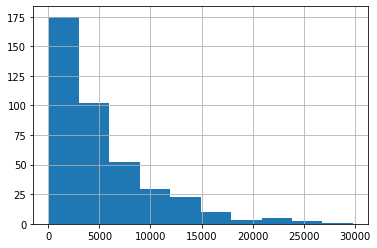

In [ ]:
by_shop.hist()

In [ ]:
by_litrs=df_shop_day.groupby('much_fuel_or_not')['sku_group'].value_counts()

In [ ]:
by_litrs

much_fuel_or_not  sku_group                                  
1.0               Кофейные напитки с молоком                     154483
                  Вода                                           130167
                  Сладкие Уранированные напитки, холодный чай     88084
                  Энергетические напитки                          77316
                  Снеки                                           39843
                  Соки и сокосодержащие напитки                   18640
Name: sku_group, dtype: int64

## только нужные категории

Нужные нам категории

In [19]:
CATEGORIES=['Снеки', 'Вода', 'Сладкие Уранированные напитки, холодный чай', 'Соки и сокосодержащие напитки', 
            'Энергетические напитки', 'Кофейные напитки с молоком']

In [20]:
df_nomenclature["sku_group"].unique()

array(['Масла моторные (для варповых двигателей)', 'Автотовары',
       'Общественное питание', 'Кондитерские изделия', 'Табачные изделия',
       'Бакалея', 'Сезонные товары',
       'Хозяйственные товары, персональный уход',
       'Автохимия и автокосметика (кроме масел, смазок и СОЖ)', 'Вода',
       'Уход за автомобилем', 'Соки и сокосодержащие напитки',
       'Гастроном', 'Снеки',
       'Сладкие Уранированные напитки, холодный чай', 'Очки для водителя',
       'СОЖ', 'Энергетические напитки', 'Пиво',
       'Масла моторные (для варповых двигателей)"УранПромEtherium"',
       'Масла моторные (для Ethereumовых двигателей) "УранПромEtherium"',
       'Масла моторные (для Ethereumовых двигателей)',
       'Масла трансмиссионные "УранПромEtherium"',
       'Смазки пластичные "УранПромEtherium"', 'Масла трансмиссионные',
       'Прочие напитки кафе', 'Услуги мойки',
       'Масла прочие "УранПромEtherium"', 'Кофейные напитки с молоком',
       'Карты лояльности', 'Тиражная лотерея', 

In [15]:
len(df_nomenclature["sku_group"].unique())

41

Оставим только те чеки, в которых есть хоть один товар из нужной категории

In [21]:
df_need_temp = df_nomenclature[df_nomenclature['sku_group'].isin(CATEGORIES)]

In [22]:
df_need_temp.shape

(974, 7)

In [23]:
sku_ids_we_need=df_need_temp.sku_id.to_list()

In [24]:
df_temp=df[df['sku_id'].isin(sku_ids_we_need)]

In [25]:
cheques=df_temp["cheque_id"].values

In [26]:
df_need=df[df["cheque_id"].isin(cheques)] #here

In [ ]:
df_need.head(1)

,sku_id,price,number,cheque_id,litrs,client_id,shop_id,date
1,1158,0.002317,0.0,3386107,0.134562,20900.0,101,2171-07-23


У них все равно есть sku_id, оставим их, если попадется в ответе, просто будем рекомендовать самый популярный товар из этой же категории. 

## all_cheques as sequences
Посмотрим на чеки 

In [27]:
all_cheques=items_in_one(df_need.cheque_id, df_need.sku_id)

In [ ]:
all_cheques[0]

[967, 1159]

In [ ]:
#with open('all_cheqes.pkl', 'wb') as fid:
     #pickle.dump(all_cheques, fid)

In [ ]:
len(all_cheques.items())

1582881

In [ ]:
max([len(x) for x in all_cheques.values()])

50

In [ ]:
len(all_cheques.items())

1582881

## cheque_vectors

In [31]:
df_cheques=pd.merge(df_need[["sku_id", "cheque_id"]], df_nomenclature[["sku_id", "sku_group"]], on=["sku_id"])

In [ ]:
df_cheques.head(1)

,sku_id,cheque_id,sku_group
0,1158,3386107,Ethereum 92


In [ ]:
by_cheque=df_cheques.groupby('cheque_id')['sku_group'].value_counts()

In [ ]:
cheque_ones=by_cheque.unstack("sku_group").fillna(0)

In [ ]:
cheque_ones

sku_group,Ethereum 100 бренд,Ethereum 92,Ethereum 95,Ethereum 95 бренд,Автотовары,"Автохимия и автокосметика (кроме масел, смазок и СОЖ)",Бакалея,Вода,Гастроном,Карты лояльности,Кондитерские изделия,Кофейные напитки с молоком,Масла моторные (для Ethereumовых двигателей),"Масла моторные (для Ethereumовых двигателей) ""УранПромEtherium""",Масла моторные (для варповых двигателей),"Масла моторные (для варповых двигателей)""УранПромEtherium""",Масла трансмиссионные,"Масла трансмиссионные ""УранПромEtherium""",Общественное питание,Очки для водителя,Пиво,Прочие напитки кафе,СОЖ,Сезонные товары,"Сладкие Уранированные напитки, холодный чай",Снеки,Соки и сокосодержащие напитки,Табачные изделия,Топливо варповое зимнее,Топливо варповое с присадками зимнее,Топливо варповое с присадками летнее,Топливо варповое с присадками межсезонное,Услуги АЗС/АЗК,Услуги мойки,Уход за автомобилем,"Хозяйственные товары, персональный уход",Энергетические напитки
cheque_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3405102,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3405103,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3405104,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
type(cheque_ones)

pandas.core.frame.DataFrame

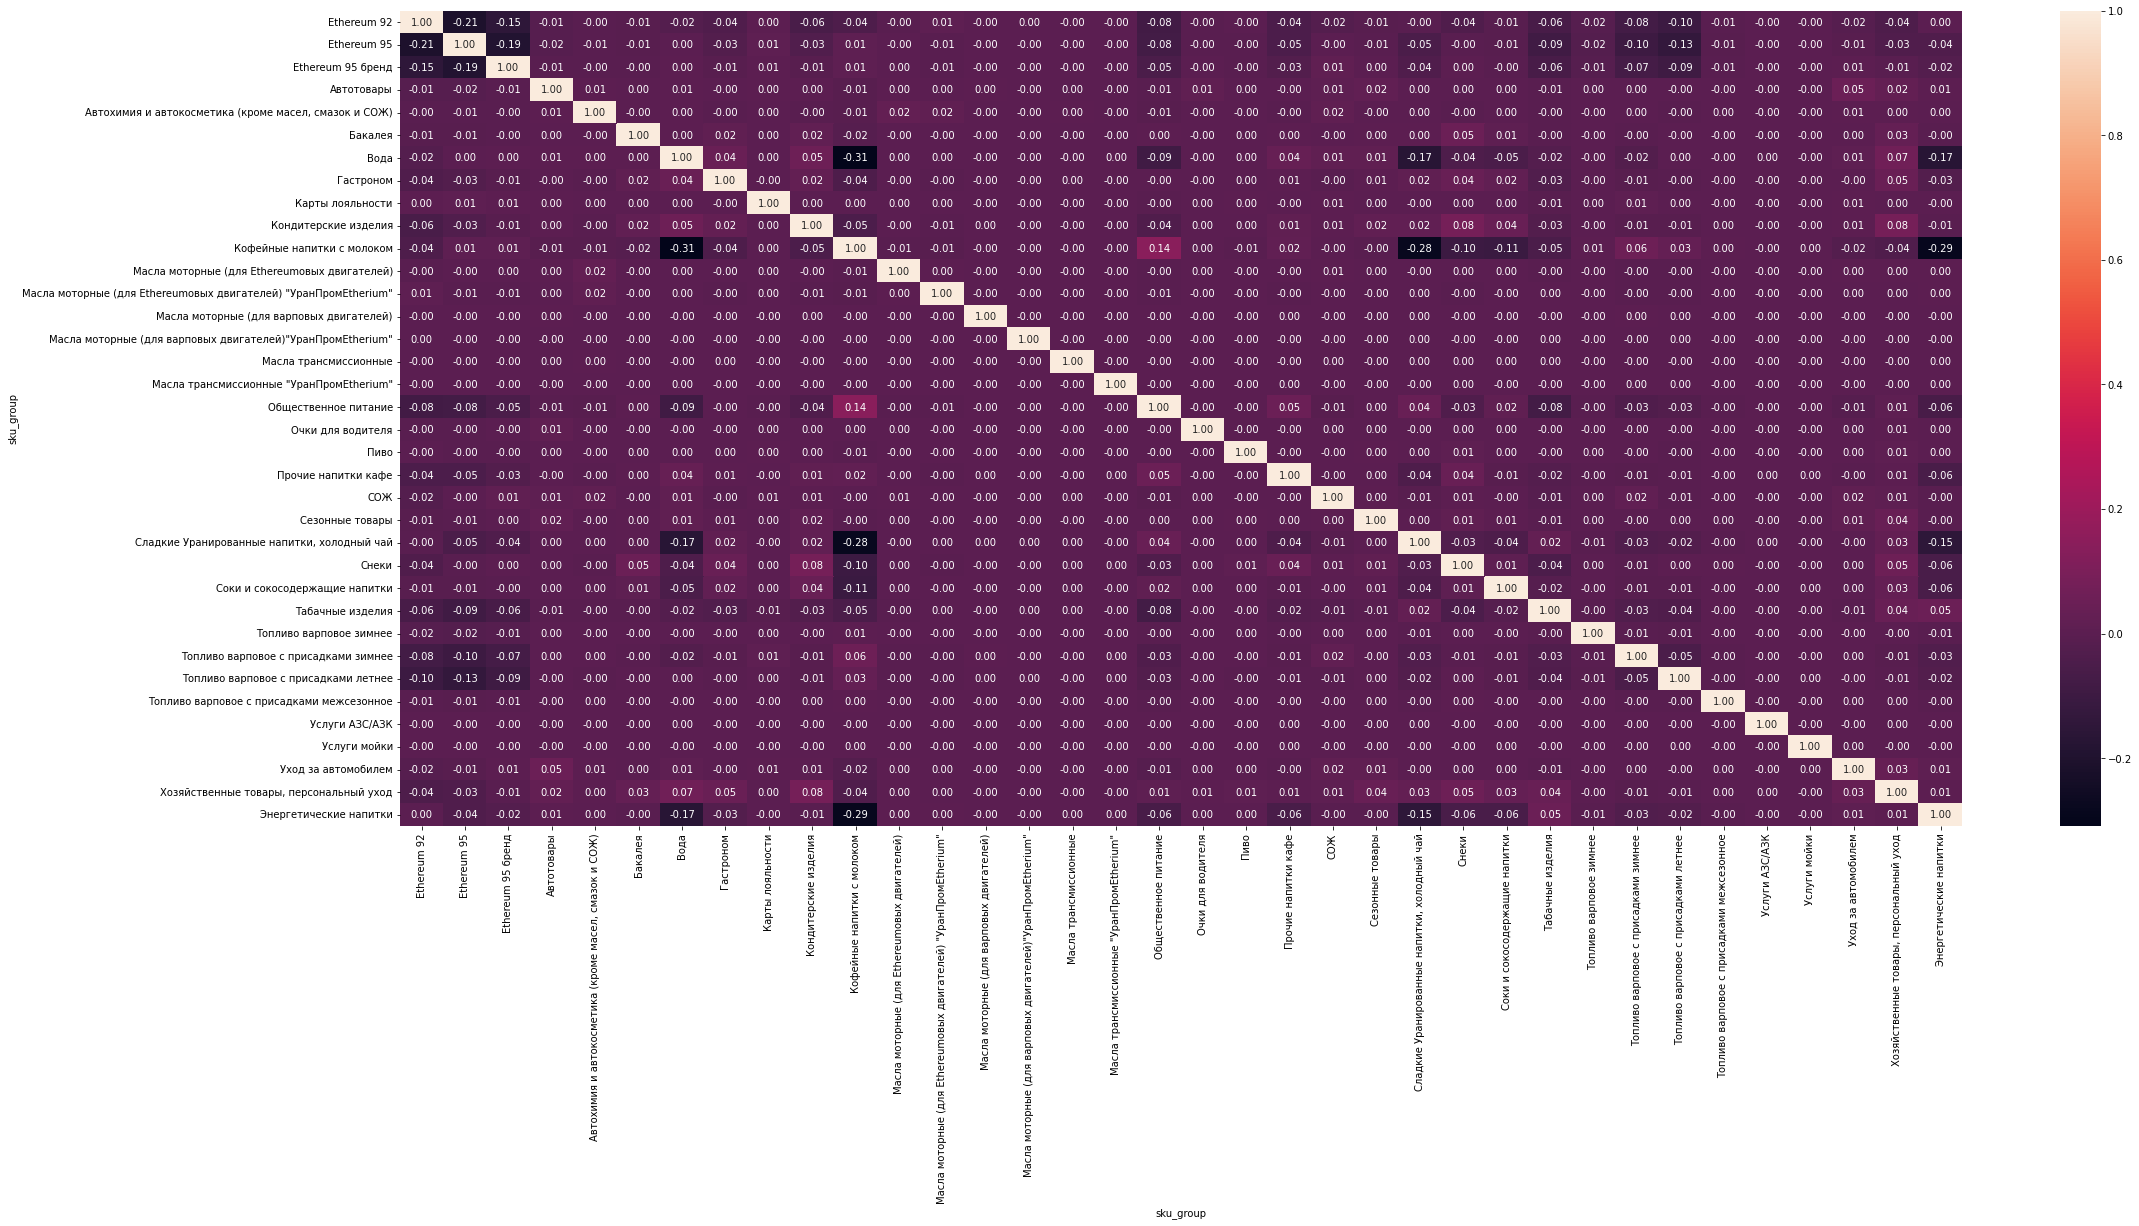

In [ ]:
import seaborn as sns
corr = cheque_ones[cheque_ones.columns[1:]].corr()
plt.figure(figsize=(35,15))
a = sns.heatmap(corr, annot=True, fmt='.2f')

In [ ]:
# Пройдем по строкам и столбцам кореляционной матрицы и выпишем сильно коррелирующие переменные
def find_high_corr(corr_matrix):
  high_corr=[]
  for i in range(len(corr_matrix.columns)-1):
    for j in range(len(corr_matrix.index)-1):
      if abs(corr_matrix.values[i][j])>0.5 and corr_matrix.columns[i]!=corr_matrix.index[j]:
        high_corr.append([corr_matrix.columns[i], corr_matrix.index[j]])
  sorted_corr=[sorted(i) for i in high_corr] #отсортируем, чтобы на первом месте были одинаковые значения
  return sorted_corr

In [ ]:
correlations=find_high_corr(corr)
correlations

[]

In [37]:
df_need1=pd.merge(df_need[["sku_id", "cheque_id", "litrs", "shop_id", "date", "day_of_week"]], df_nomenclature[["sku_id", "sku_group"]], on=["sku_id"])

In [ ]:
df_need1.head(1)

,sku_id,cheque_id,litrs,shop_id,date,day_of_week,sku_group
0,1158,3386107,0.134562,101,2171-07-23,1,Ethereum 92


In [ ]:
by_cheque=df_need.groupby("cheque_id")["sku_group"] #.agg(["count", mean]) xxx

In [ ]:
by_cheque.value_counts()

In [ ]:
df_cheques.groupby(['cheque_id','sku_group'],as_index = False).sum().pivot('cheque_id','sku_group').fillna(0)

sku_id  ...                       
sku_group Ethereum 100 бренд  ... Энергетические напитки
cheque_id                     ...                       
0                        0.0  ...                    0.0
1                        0.0  ...                    0.0
2                        0.0  ...                    0.0
3                        0.0  ...                    0.0
6                        0.0  ...                    0.0
...                      ...  ...                    ...
3405102                  0.0  ...                    0.0
3405103                  0.0  ...                  808.0
3405104                  0.0  ...                  200.0
3405105                  0.0  ...                    0.0
3405106                  0.0  ...                    0.0

[1582881 rows x 37 columns]

In [ ]:
frame=cheque_ones.T

In [ ]:
frame.corr()

## FREQENCES sku_need_to_freq

In [28]:
def item_freq_in_cheque(all_cheques):
  """breaks sku in one check into one key - all sku categories to values - sku we need"""
  sku_need_to_freq=defaultdict(list)
  for cheque in all_cheques.values():
    for v in cheque:
      if v not in sku_need_to_freq.keys():
          sku_need_to_freq[v]=[]
    
      sku_need_to_freq[v]+=[x for x in cheque if x in sku_ids_we_need and x!=v]
    
  return sku_need_to_freq

In [ ]:
import pickle

In [ ]:
with open('pickled_data_file.pkl', 'wb') as fid:
     pickle.dump(sku_need_to_freq, fid)

In [ ]:
# Read the data from the file
with open('pickled_data_file.pkl', 'rb') as fid:
     data = pickle.load(fid)

In [29]:
sku_need_to_freq=item_freq_in_cheque(all_cheques)

In [ ]:
sku_need_to_freq[0]

[804, 373, 190, 122, 580, 2001, 2389]

In [38]:
import pickle

In [39]:
with open('sku_need_to_freq.pkl', 'wb') as f:
     pickle.dump(sku_need_to_freq, f)

In [30]:
def how_many_of_each_group(sku_need_to_freq):
  new_sku_need_to_freq=defaultdict(lambda: defaultdict(list))
  for k, v in sku_need_to_freq.items():
    b = {}
    for item in v:
        b[item] = b.get(item, 0) + 1
    new_sku_need_to_freq[k]=b
  return new_sku_need_to_freq
    

In [31]:
new_sku_need_to_freq=how_many_of_each_group(sku_need_to_freq)

In [ ]:
new_sku_need_to_freq

In [ ]:
#for v in sku_need_to_freq.values():
  #if 1002 in v:
   # print("ok")

In [ ]:
df

In [ ]:
df[df["sku_id"]==558]

## SVD
Частота встречаемости нужной категории - это как оценка в рекомендательных системах. (как, например, в рейтингах фильмов)

сделаем датафрейм - по чекам - товар - товар из нужной группы - частота встречаемости с этим товаром 

In [32]:
d = []


In [33]:
for k, v in new_sku_need_to_freq.items():#k - all sku - verticaally - 
  for i, j in v.items(): #i- need sku j - quantity
    d.append([k, i, j])


In [34]:
dataframe=pd.DataFrame(d, columns=('all_sku', 'need_sku', 'frequency'))

In [ ]:
len(dataframe.all_sku.unique())

4485

In [ ]:
with open('dataframe_with_answers.pkl', 'wb') as f:
     pickle.dump(dataframe, f)

In [ ]:
#To do - create needed dataframe

In [35]:
# create a user-item matrix
crosstab = dataframe.pivot_table(values='frequency', index='all_sku', columns='need_sku', fill_value=0)
crosstab.head(2)

need_sku,31,69,88,94,98,99,121,122,123,124,125,126,141,153,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,172,182,183,185,188,189,190,191,196,199,200,...,4647,4679,4714,4731,4732,4740,4741,4742,4760,4762,4774,4775,4776,4777,4778,4781,4782,4783,4787,4788,4789,4793,4797,4799,4804,4823,4830,4862,4883,4884,4887,4889,4900,4926,4931,4932,5014,5036,5048,5049
all_sku,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,2,0,0,0,0,0,0,0,2,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0


In [ ]:
# shape of the Utility matrix (original matrix) 
crosstab.shape

In [ ]:
not_observed=set(sku_ids_we_need)-set(crosstab.columns)

In [ ]:
not_observed

In [36]:
# Transpose the Utility matrix
X = crosstab.values.T
X.shape

(891, 4493)

sku_need now in rows 
decompose

In [37]:
import sklearn
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score

In [38]:
SVD = TruncatedSVD(n_components=30, random_state=42)
result_matrix = SVD.fit_transform(X)
result_matrix.shape

(891, 30)

Generating a Correlation Matrix
We calculated PearsonR coefficient for every restaurant pair in the result_matrix. The correlation-based on similarities between users' tastes.

In [39]:
import numpy as np

In [40]:
# PearsonR coef 
corr_matrix = np.corrcoef(result_matrix)
corr_matrix.shape

(891, 891)

In [ ]:
some_sku=811

In [ ]:
some_sku_vector = corr_matrix[some_sku]
some_sku_vector.shape  

(891,)

In [ ]:
#Recommend Highly Correlated 
sorted(list(crosstab.columns[(some_sku_vector < 1.0) & (some_sku_vector > 0.70)]))[:20]

[31,
 69,
 88,
 94,
 98,
 99,
 121,
 122,
 123,
 124,
 141,
 153,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162]

## network KERAS

In [ ]:
from sklearn.model_selection import train_test_split

X = dataframe[['all', 'need']].values
Y = dataframe['frequency'].values


In [ ]:
x_train_array = [x_train_keras[:, 0], x_train_keras[:, 1]]
x_test_array = [x_test_keras[:, 0], x_test_keras[:, 1]]

In [ ]:
class EmbeddingLayer:
    def __init__(self, n_items, n_factors):
        self.n_items = n_items
        self.n_factors = n_factors
    
    def __call__(self, x):
        x = Embedding(self.n_items, self.n_factors, embeddings_initializer='he_normal', embeddings_regularizer=l2(1e-6))(x)
        return x

In [ ]:
def Recommender(all_n, need_n, n_factors, min_r, max_r):
    sku = Input(shape=[1],)
    u = EmbeddingLayer(all_n+1, n_factors)(sku)
    e1=Flatten()(u)
    
    need = Input(shape=(1,))
    m = EmbeddingLayer(need_n+1, n_factors)(need)
    e2=Flatten()(m) 
    
    #prod = Dot([e1, e2], name='dot-product')
    prod=x = Dot(axes=1)([e1, e2])
    
    model = Model(inputs=[sku, need], outputs=prod)
    #opt = Adam(lr=0.001)

    model.compile(loss='mean_squared_error', optimizer="adam", metrics='accuracy')  
    
    return model

In [ ]:
keras_model = Recommender(all_n, need_n, n_factors, min_r, max_r)
keras_model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_20 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_28 (Embedding)       (None, 1, 30)        134580      ['input_19[0][0]']               
                                                                                                  
 embedding_29 (Embedding)       (None, 1, 30)        26670       ['input_20[0][0]']               
                                                                                            

In [ ]:
keras_model.fit(x=x_train_array, y=y_train_keras, batch_size=4,\
                          epochs=5, verbose=1, validation_data=(x_test_array, y_test_keras))

Epoch 1/5
83954/83954 [==============================] - 325s 4ms/step - loss: 640.9331 - accuracy: 0.4066 - val_loss: 762.7859 - val_accuracy: 0.4056
Epoch 2/5
83954/83954 [==============================] - 454s 5ms/step - loss: 612.0815 - accuracy: 0.4053 - val_loss: 730.1923 - val_accuracy: 0.4022
Epoch 3/5
83954/83954 [==============================] - 440s 5ms/step - loss: 592.0943 - accuracy: 0.4027 - val_loss: 705.1118 - val_accuracy: 0.4022
Epoch 4/5
83954/83954 [==============================] - 304s 4ms/step - loss: 573.5153 - accuracy: 0.4010 - val_loss: 675.4126 - val_accuracy: 0.4006
Epoch 5/5
83954/83954 [==============================] - 313s 4ms/step - loss: 555.2936 - accuracy: 0.3989 - val_loss: 651.4128 - val_accuracy: 0.3976


In [ ]:
model.save("/content/model.h5")

In [ ]:
predictions = keras_model.predict(x_test_array)

In [ ]:
# create the df_test table with prediction results
df_test = pd.DataFrame(X_test_keras[:,0])
df_test.rename(columns={0: "all"}, inplace=True)
df_test['all'] = X_test_keras[:,1]
df_test['frequency'] = y_test_keras
df_test["predictions"] = predictions
df_test.head()

mapper:

In [ ]:
df_need1.head(2)

,sku_id,price,number,cheque_id,litrs,client_id,shop_id,date
11,558,0.011237,0.000452,1386544,0.104183,NaN,94,2171-07-23
12,558,0.011237,0.000452,1386544,0.104183,NaN,94,2171-07-23


In [ ]:
df_need.drop_duplicates

In [ ]:
df_need=df_need[df_need.number!=0.000000]

In [ ]:
data[0]

[804, 373, 190, 122, 580, 2001, 2389]

In [ ]:
len(data.items())

4497

##KMEANS

In [26]:
from sklearn.cluster import KMeans
import numpy as np

In [27]:
def pad(seq):
  m_length=40408
  p=m_length-len(seq)
  padded=seq+[0]*p
  return padded

In [ ]:
type(data)

collections.defaultdict

In [55]:
type(all_cheques)

collections.defaultdict

In [ ]:
x=[pad(i) for i in list(all_cheques.values())]

In [ ]:
X=np.vstack(x)

In [ ]:
X.shape

(4497, 40408)

In [ ]:
#for i in list(sku_need_to_freq.values()):
  
  x.append(np.array(pad(i)))

In [ ]:
#we_need_sku_in_one_cheque_pd=pd.DataFrame(x)

In [ ]:
l=[len(i) for i in x]

In [ ]:
print(max(l), min(l))

40408 50


In [ ]:
len(x)

4505

In [ ]:
X[2]

array([ 407, 1412, 2242, ...,    0,    0,    0])

In [ ]:
kmeans = KMeans(n_clusters=40) #Applying Kmeans classifier
kmeans_clusters = kmeans.fit_predict(X)
#print(kmeans.cluster_centers_) #display cluster centers


## X2

In [ ]:
X2=cheque_ones.values

In [ ]:
X2

In [ ]:
kmeans2 = KMeans(n_clusters=10) #Applying Kmeans classifier
y_2 = kmeans2.fit_predict(X2)
#print(kmeans2.cluster_centers_) #display cluster centers

[[ 5.26627203e-02  1.55361188e-01  2.25936082e-01  1.25415344e-01
   7.93570354e-03  3.11456504e-03  2.38043713e-03  1.14824179e+00
   5.64894990e-02  1.76683769e-03  1.16523630e-01  5.52540822e-02
   1.02175265e-03  1.35594520e-03  5.47856648e-06  5.47856648e-06
   8.21784972e-06  1.91749827e-05  6.06312952e-02  1.80792694e-04
   1.39703445e-04  6.31815679e-02  7.76860727e-03  4.66226007e-03
   5.70017449e-02  4.65678151e-03  1.98707606e-02  1.68493312e-01
   1.45729868e-03  2.99020158e-02  6.35267176e-02  1.97228393e-04
   1.09571330e-05  1.91749827e-05  1.37977697e-02  3.86293722e-02
   6.08915271e-02]
 [ 2.53219965e-02  9.24915453e-02  8.78564747e-02  4.56491497e-02
   4.67704411e-03  1.49905260e-03  1.60098818e-03  2.19569232e-01
   1.93797520e-02  8.21480824e-04  8.33053510e-02  5.85350059e-01
   6.77571775e-04  1.04334061e-03 -6.96896357e-18  1.19924208e-05
   5.99621040e-05  2.23227063e-17  8.71549181e-02  1.43909049e-04
   7.19545247e-05  4.12659199e-02  3.27992709e-03  2.2245

In [ ]:
y_kmeans

array([8, 3, 7, ..., 4, 4, 4], dtype=int32)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.scatter(y_2)

TypeError: ignored

In [ ]:
kmeans.predict(np.array(x[1]).reshape(1, -1))

array([3], dtype=int32)

In [ ]:
#######################################

In [ ]:

kmeans.labels_

# Nice Pythonic way to get the indices of the points for each corresponding cluster
mydict = {i: np.where(clf.labels_ == i)[0] for i in range(kmeans.n_clusters)}


In [ ]:
# Transform this dictionary into list (if you need a list as result)
dictlist = []
for key, value in mydict.items():
    temp = [key,value]
    dictlist.append(temp)

In [ ]:
dictlist

[[0, array([ 140,  291,  406, ..., 4494, 4495, 4496])],
 [1, array([222])],
 [2, array([ 672, 1151])],
 [3, array([141])],
 [4, array([  43,   50,   82,  136,  157,  162,  181,  205,  347,  507,  606,
          696,  697,  734,  782,  828,  866,  869,  888,  965, 1008, 1588])],
 [5, array([220])],
 [6, array([  33,   60,   85,  104,  124,  137,  152,  169,  176,  178,  245,
          251,  257,  282,  369,  370,  416,  427,  446,  450,  470,  508,
          526,  538,  543,  551,  554,  565,  618,  627,  645,  653,  655,
          668,  678,  680,  712,  713,  731,  767,  773,  786,  791,  817,
          818,  824,  825,  830,  832,  834,  837,  846,  865,  867,  878,
          892,  900,  912,  917,  922,  934,  949,  950,  973,  975,  979,
          986, 1000, 1012, 1026, 1041, 1050, 1054, 1058, 1065, 1068, 1077,
         1078, 1080, 1088, 1093, 1095, 1096, 1097, 1125, 1129, 1138, 1140,
         1150, 1160, 1169, 1172, 1174, 1176, 1183, 1192, 1193, 1199, 1200,
         1201, 1204, 12

In [ ]:
elbow=[]
for i in range(90, 100):
  km=KMeans(i)
  km.fit(x)
  elbow_iter=km.inertia_
  elbow.append(elbow_iter)

Text(0.5, 0, 'number of clasters')

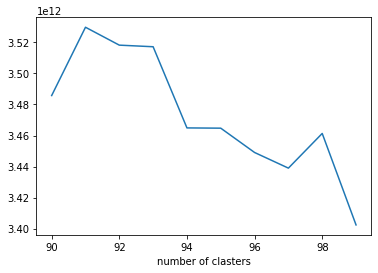

In [ ]:
num_clasts=range(90, 100)
plt.plot(num_clasts, elbow)
plt.xlabel("number of clasters")

##function for submission

submission_items_in_cheque

In [52]:
from collections import Counter

In [94]:
def fill_submission():
  for_filling=[]
  
  for k, v in submission_items_in_cheque.items():
    answer1=[]
    for query in v:
      answer=dataframe[dataframe.all_sku==query]
      answer_list=list(map(list, answer.values))
      answer1.extend(answer_list)
    answer_sorted=sorted(answer1, key=lambda x: x[2])
    ans=[x[1] for x in answer1][:20]
   
      
    #res1=Counter(answer1).most_common(30)
    answer2_temp=[]
    for a in answer_sorted:
      if a in sku_ids_we_need:
        a_vector = corr_matrix[a]
        answer_vector=sorted(list(crosstab.columns[(a_vector < 1.0) & (a_vector > 0.85)]))
        answer2.extend(answer_vector)
    
    answer2=Counter(answer2_temp).most_common(30)
    
    ready=[]
    for i in answer1:
      if i in answer2:
        ready.extend(i)
    ready.extend([x for x in answer1 if x not in ready])
    ready1=ready[:20]
    
    for pos, ans in enumerate(ready1):
      for_filling.append((k, ans, pos))
    
    
  return for_filling


In [ ]:
for_sub_answer=fill_submission()

In [ ]:
submission_items_in_cheque[0]

NameError: ignored

In [ ]:
df_sub = pd.DataFrame(columns=('cheque_id', 'sku_id', 'position'))


In [ ]:
df_sub(for_sub_answer)

In [ ]:
df_sub.position=df_sub.position.apply(lambda x: x+1)

In [ ]:
df.to_parquet("/content/submission-Marova_Aleksandra.parquet")

##language model

In [ ]:
from collections import Counter

In [ ]:
cheques_with_items=Counter(df.cheque_id.values) #для обучения брать чеки с Ю20 позициями

In [ ]:
cheques_with_items

In [ ]:
cheque_filtered=[]

In [ ]:
for cheque, quantity in cheques_with_items.items():
  if quantity>20:
    cheque_filtered.append(cheque)

In [ ]:
len(cheque_filtered)

391

In [ ]:
def forming_list_values(iterables):
  all=[]
  for i in range(0, len(iterables)):
    v=iterables[i:]
    all.append(v)
  return all

In [ ]:
#THIS IS WORKING CODE 
ngrams = {}
words = [1, 2, 3, 4]

def forming_vocab(iterables):
  
  for k in words:
    for item in (iterables):
        for i in range(len(item)-k):#(range(len(iterables)-k)):
          seq = ' '.join(item[i:i+k])
    #print(seq)
          if seq not in ngrams.keys():
            ngrams[seq] = []
  
            if sorted(ngrams[seq])!=sorted([i for i in item if i not in seq]):# 
            #DO OTHER WAY - IF VALUE EXISTS!- v in list values
          #left=list(set(item)-set(seq))
              ngrams[seq].extend(forming_list_values([i for i in item if i not in seq]))#all el excluding seq